In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
import corner
import emcee
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
from ltsfit.lts_linefit import lts_linefit

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
df = pd.read_csv("edd_cf4_refined.csv", sep='|')


for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df['D75'] = df.Vmod / 75.
df['logD75'] = np.log10(df.Vmod / 75.)
df['DM_75'] = 5*df.logD75 + 25 
df['Mg_75'] = df['g***'] - df.DM_75
df['Mr_75'] = df['r***'] - df.DM_75
df['Mi_75'] = df['i***'] - df.DM_75
df['Mz_75'] = df['z***'] - df.DM_75
df['M1_75'] = np.asarray([np.float64(x) for x in df['w1***'].values]) - df.DM_75.values
df['M2_75'] = np.asarray([np.float64(x) for x in df['w2***'].values]) - df.DM_75.values

df['gi'] = df['g***'] - df['i***']
df['rz'] = df['r***'] - df['z***']
df['gz'] = df['g***'] - df['z***']


print(df.columns)
print(len(df))

df.head()

Index(['PGC', 'Name', 'Vhel', 'Vls', 'u', 'g', 'r', 'i', 'z', 'w1',
       ...
       'DM_75', 'Mg_75', 'Mr_75', 'Mi_75', 'Mz_75', 'M1_75', 'M2_75', 'gi',
       'rz', 'gz'],
      dtype='object', length=119)
10737


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,PGC,Name,Vhel,Vls,u,g,r,i,z,w1,...,DM_75,Mg_75,Mr_75,Mi_75,Mz_75,M1_75,M2_75,gi,rz,gz
0,2,UGC12889,5017.0,5309.5,0.00,0.00,0.00,0.00,0.00,11.86,...,34.024557,-34.024557,-34.024557,-34.024557,-34.024557,-22.134557,-21.504557,0.00,0.00,0.00
1,4,PGC000004,4458.0,4706.1,17.57,16.43,15.91,15.57,15.42,16.06,...,33.717026,-18.127026,-18.387026,-18.597026,-18.647026,-17.647026,-17.277026,0.47,0.26,0.52
2,12,PGC000012,6531.0,6667.6,0.00,0.00,0.00,0.00,0.00,13.60,...,34.620362,-34.620362,-34.620362,-34.620362,-34.620362,-21.030362,-20.390362,0.00,0.00,0.00
3,16,PGC000016,5713.0,5855.1,16.08,14.83,14.21,13.86,13.61,13.98,...,34.281429,-19.921429,-20.421429,-20.701429,-20.881429,-20.291429,-19.581429,0.78,0.46,0.96
4,55,UGC12898,4779.0,5052.2,16.82,16.08,15.71,15.50,15.40,16.18,...,33.894131,-18.364131,-18.574131,-18.674131,-18.724131,-17.694131,-17.264131,0.31,0.15,0.36


In [4]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

[0.3797105  1.61565606]
sig_int:     0.0000      0.6911
Computing sig_int
sig_int:     0.0000      0.6911
sig_int:     0.0749     -0.4304
sig_int:     0.0461     -0.0264
sig_int:     0.0443      0.0029
sig_int:     0.0445     -0.0004
sig_int:     0.0445      0.0000
Computing sig_int error
sig_int:     0.0445      0.0306
sig_int:     0.0749     -0.3998
sig_int:     0.0467     -0.0049
sig_int:     0.0464      0.0004
sig_int:     0.0464     -0.0000
Repeat at best fitting solution
sig_int:     0.0445      0.0000
################# Values and formal errors ################
 intercept:  1.5773 +/- 0.0045
     slope:  0.4357 +/- 0.0068
   scatter:  0.0445 +/- 0.0019
Observed rms scatter: 0.070
Spearman r=0.77 and p=0
Pearson r=0.64 and p=9.5e-253
##########################################################
seconds 18.99
0.4356745683052831 1.5772902795261527


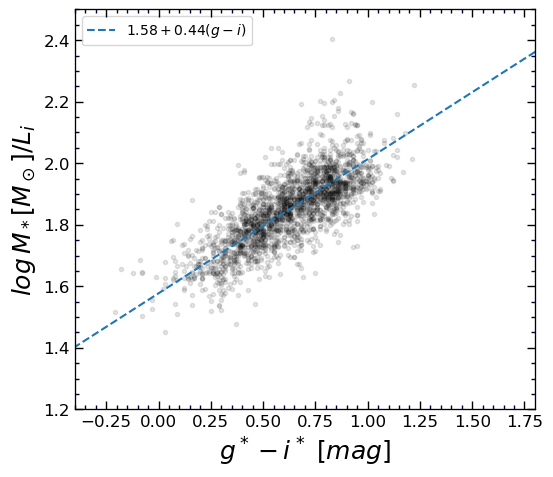

In [5]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1



df['iw'] = df['i***']-df['w1***']
# df['iw'] = df['Mi_75'] - df['M1_75']
df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mi_75']


dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)].dropna()

X0 = dff.gi.values
Y0 = dff.logMs.values # +  (0.142*dff.lgWmxi.values - 0.366)
Vmod = dff.Vmod.values

ax.plot(X0, Y0, 'k.', alpha=0.1)


set_axes(ax, (-0.4,1.8), (1.2,2.5), fontsize=12)


def func(x, m, b):
    return m*x+b
    

fit, cov = curve_fit(func, X0, Y0)

linear = odr.Model(f)
mydata = odr.Data(X0, Y0)
myodr = odr.ODR(mydata, linear, beta0=[1,1])
myoutput = myodr.run()
print(myoutput.beta)

m = myoutput.beta[0]
b = myoutput.beta[1]
m0 = fit[0]
b0 = fit[1] 
# m = 1./m
# b = -b*m


mcfit = lts_linefit(X0, Y0, X0*0+0.07, Y0*0+0.11*0.4, clip=3., plot=False)
m = mcfit.ab[1]
b = mcfit.ab[0]

gi = np.linspace(-1,2)
# ax.plot(gi, 0.7*gi+1.15, 'r-', label=r'$\Upsilon^*_i=-0.68+0.70(g-i)$')
# ax.plot(gi, m0*gi+b0, 'b-', label=r'$\Upsilon_*=-0.68+0.7(g-i)$')
ax.plot(gi, m*gi+b, '--', label=r'$1.58+0.44(g-i)$')


mask = ~mcfit.mask
xx = X0[mask]
yy = Y0[mask]

yy0 = m*xx+b
xx1 = xx[yy>yy0]
yy1 = yy[yy>yy0]
# ax.plot(xx1, yy1, 'r.', alpha=0.5)


yy0 = m*xx+b
xx1 = xx[yy<yy0]
yy1 = yy[yy<yy0]
# ax.plot(xx1, yy1, 'b.', alpha=0.5)

print(m, b)

# dff = df[(df.Qs>2)&(df.Qw>0)&(df.gi>-1)&(df.logMs<10)].dropna()
# dff['delta'] = (m*dff.gi+b)-dff.logMs
# std = dff['delta'].std()
# dff = dff[np.abs(dff.delta)<3.5*std]

ax.set_xlabel(r'$g^*-i^* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_*[M_\odot]/L_{i}$', fontsize=18)
# ax.set_title(r'$\Upsilon_*=0.5\/\/ [M_{\odot}/L_{\odot}]_{W1}$', fontsize=16)

ax.legend()        

In [6]:
# [0.35859423 1.64789521]
# 0.3585942298475359 1.6478952116460055


In [7]:
PGC = dff.PGC.values
PGC[mask][yy>yy0]

array([ 2080,  3084,  3174,  3235,  3717,  4539,  4948,  6982,  9399,
       25102, 28026, 30358, 32707, 35942, 36466, 40581, 42681, 42938,
       42975, 45887, 50012, 50782, 51450, 53728, 54431, 55281, 69016,
       91252])

In [8]:
PGC[mask][yy<yy0]

array([  3081,   3247,  36778,  37164,  39632,  43944,  85607, 138562])

No handles with labels found to put in legend.


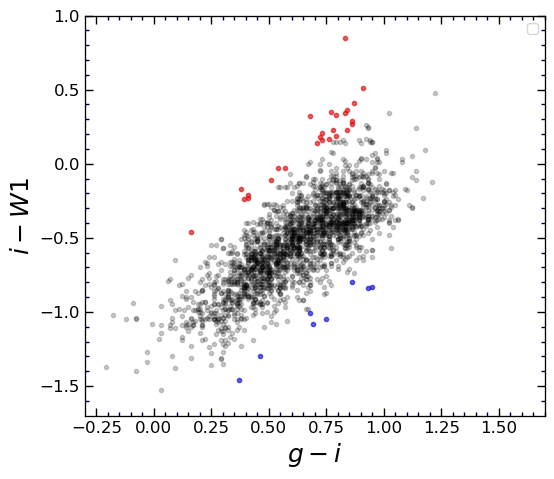

In [9]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1



X0 = dff.gi.values
Y0 = dff.iw.values 
Vmod = dff.Vmod.values

ax.plot(X0, Y0, 'k.', alpha=0.2)


set_axes(ax, (-0.3,1.7), (-1.7,1.0), fontsize=12)


xx = X0[mask]
YY = Y0[mask]

xx1 = xx[yy>yy0]
yy1 = YY[yy>yy0]
ax.plot(xx1, yy1, 'r.', alpha=0.5)


xx1 = xx[yy<yy0]
yy1 = YY[yy<yy0]
ax.plot(xx1, yy1, 'b.', alpha=0.5)


ax.set_xlabel(r'$g-i $', fontsize=18) 
ax.set_ylabel(r'$i-W1 $', fontsize=18)

ax.legend()        